# Fit with HA model

In [547]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import importlib
import logging
import pickle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import jv
from scipy.interpolate import interp1d
from numpy.typing import NDArray

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

from theory.carlosha.ha import get_current_ha
importlib.reload(sys.modules["theory.carlosha.ha"])

from theory.carlosfcs.fcs import get_current_fcs
importlib.reload(sys.modules["theory.carlosfcs.fcs"])

from theory.dynes.dynes import get_current_dynes
importlib.reload(sys.modules["theory.dynes.dynes"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from scipy.constants import e, h
G_0 = 2 * e**2 / h



In [ ]:
# one function to rule them all
# get_current
# This function calculates the current for a given voltage, energy gap, transmission, temperature, dynes parameter, and model.
# It supports three models: "ha" (Hamiltonian approach), "dynes" (Dynes model), and "fcs" (FCS model).
# Parameters:
# - voltage_mV: Array of voltages in millivolts.
# - energy_gap_V: Energy gap in volts (default is 2e-4 V).
# - transmission: Transmission coefficient (default is 0.5). Can be a single value or an array.
# - temperature_K: Temperature in Kelvin (default is 0.0 K).
# - dynes_parameter_V: Dynes parameter in volts (default is 0.0 V).
# - modell: Model to use for current calculation. Options are "ha", "dynes", and "fcs" (default is "ha").
# Returns:
# - all_currents_nA: A 2D array of calculated currents in nanoamperes (nA).
# Each row corresponds to a different transmission value, and each column corresponds to a different voltage.

def get_current(
    voltage_mV: np.ndarray,
    energy_gap_V: float = 2e-4,
    transmission: float | np.ndarray = 0.5,
    temperature_K: float = 0.0,
    dynes_parameter_V: float = 0.0,
    modell: str = "ha",
) -> np.ndarray:
    
    if type(transmission) is not np.ndarray:
        transmission = np.full((1), transmission)

    all_currents_nA = np.full((transmission.shape[0], voltage_mV.shape[0]), np.nan)

    for i, tau in enumerate(transmission):
        match modell:
            case "dynes":
                all_currents_nA[i,:] = get_current_dynes(
                    voltage_mV=voltage_mV,
                    energy_gap_V=energy_gap_V,
                    conductance=tau,
                    dynes_parameter_V=dynes_parameter_V,
                )
            case "ha":
                all_currents_nA[i,:] = get_current_ha(
                    voltage_mV=voltage_mV,
                    energy_gap_V=energy_gap_V,
                    transmission=tau,
                    temperature_K=temperature_K,
                )
            case "fcs":
                tmp_current = get_current_fcs(
                    voltage_mV=voltage_mV,
                    energy_gap_V=energy_gap_V,
                    transmission=tau,
                    temperature_K=temperature_K,
                )
                all_currents_nA[i,:] = np.sum(tmp_current, axis=1)
            case _:
                raise ValueError(f"Unknown model: {modell}")
    return all_currents_nA

- retrieve experimental data

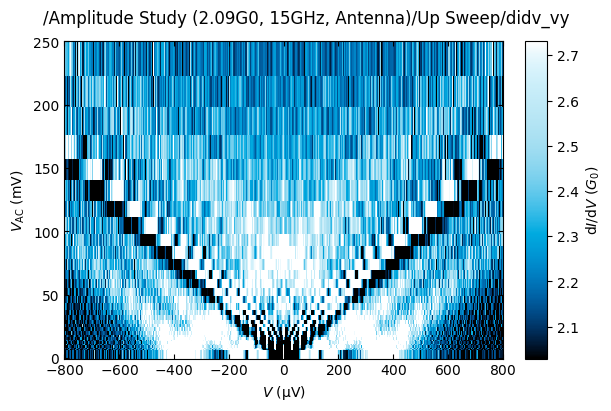

In [367]:
# get exp data
%matplotlib inline

from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])

from contextlib import contextmanager
@contextmanager
def suppress_logging():
    logger = logging.getLogger()
    original_level = logger.level
    logger.setLevel(logging.CRITICAL)
    try:
        yield
    finally:
        logger.setLevel(original_level)

with suppress_logging():
    eva = IVPlot()
    eva.file_directory = '/Volumes/speedyboy/measurement data 2/'
    eva.file_folder = '2023-11-03_1_G0/'
    eva.file_name = '2023-11-04_G0_antenna.hdf5'

    eva.setAmplifications(10000, 1000)
    eva.setV(.8e-3, voltage_bins=1600)
    eva.setI(200e-9, current_bins=1000)
    eva.setA(0, 0.25, 250)
    eva.downsample_frequency = 43

    # Amplitude Study (2.09, 15GHz, Antenna)
    eva.title = "Amplitude Study (2.09G0, 15GHz, Antenna)"
    eva.sub_folder = ""
    eva.data_folder = "exp_data"

    # eva.setMeasurement("frequency_at_15GHz")
    # eva.setKeys(index_0=3, index_1=-3, norm=1, to_pop = 'nu=-31.0dBm')
    # eva.showKeys()
    # eva.addKey('nu=-31.0dBm', -1000)
    # eva.up_sweep, = eva.getMaps([1])
    # eva.up_sweep, = eva.getMapsAmplitude([eva.up_sweep])
    # eva.y_axis = eva.amplitude_axis
    # eva.saveData()

    eva.loadData()
    eva.figure_folder = "exp_data"
    eva.to_plot = eva.up_sweep
    eva.title_of_plot = "Up Sweep"
    eva.y_characters = [r"$V_\mathrm{AC}$", "V"]
    eva.smoothing = True
    eva.window_length = 5
    eva.plot_T = False
    eva.plot_dvdis = False
    eva.plot_all()

- extract V_nu = 0

In [560]:
from utilities.basefunctions import bin_y_over_x
importlib.reload(sys.modules["utilities.basefunctions"])

voltage_mV = np.linspace(-.8, .8, 401)

voltage_exp_mV = eva.mapped["voltage_axis"] * 1e3  # Convert V to mV
current_exp_nA = eva.up_sweep['current'][0, :] * 1e9
conductance_exp = np.gradient(current_exp_nA, voltage_exp_mV) * 1e-6 / G_0


Text(0.5, 0, '')

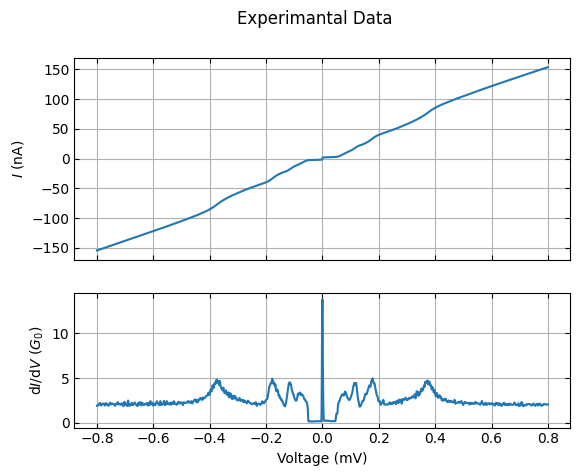

In [561]:
# show currents and conductance from Hamiltonian Approach
%matplotlib inline
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

fig.suptitle('Experimantal Data')
ax0.plot(voltage_exp_mV, current_exp_nA, '-')
ax1.plot(voltage_exp_mV, conductance_exp, '-')
ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (mV)")

ax0.sharex(ax1)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

In [562]:
# remove Supercurrent Peak at V=0
%matplotlib inline

lower_index = 750
upper_index = 847
temp = np.ones((upper_index-lower_index)) * (conductance_exp[lower_index] + conductance_exp[upper_index]) / 2
temp = np.zeros(upper_index-lower_index)
conductance_exp[lower_index:upper_index] = temp

import numpy as np
from scipy.integrate import cumulative_trapezoid

def integrate_with_anchor(y, x, anchor=(0., 0.)):
    """
    Numerically integrates y over x using trapezoidal rule,
    and shifts the result so that F(x_0) = y_0.

    Returns an array with the same shape as y.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    x_0, y_0 = anchor

    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")
    if not np.all(np.diff(x) > 0):
        raise ValueError("x must be strictly increasing")

    # Do trapezoidal integration from x[0]
    F = np.zeros_like(y)
    F[1:] = cumulative_trapezoid(y, x)

    # Interpolate to find the value of the integral at x_0
    F_at_x0 = np.interp(x_0, x, F)

    # Shift so that F(x_0) = y_0
    return F - F_at_x0 + y_0

current_exp_nA = integrate_with_anchor(conductance_exp, voltage_exp_mV) / 1e-6 * G_0  # Convert A to nA

- initial guesses

In [575]:
pincode = np.array([0.8, 0.62, 0.33, 0.25])

energy_gap_eV = 220.5e-6
temperature_K = 0.8
dynes_parameter_eV = 20e-6 #4e-6

In [576]:
all_current_theo_nA = get_current(
        voltage_mV=voltage_mV,
        energy_gap_V=energy_gap_eV,
        transmission=pincode,
        temperature_K=temperature_K,
        dynes_parameter_V=dynes_parameter_eV,
        modell = "fcs",
    )
all_current_theo_nA /= 2
current_theo_nA = np.sum(all_current_theo_nA, axis=0) 
all_conductance_theo = np.gradient(all_current_theo_nA, voltage_mV, axis=1) * 1e-6 / G_0
conductance_theo = np.gradient(current_theo_nA, voltage_mV) * 1e-6 / G_0

cached values: 0/201


IV simulations: 100%|██████████| 201/201 [00:55<00:00,  3.65sim/s]


cached values: 0/201


IV simulations: 100%|██████████| 201/201 [00:59<00:00,  3.40sim/s]


cached values: 0/201


IV simulations: 100%|██████████| 201/201 [00:59<00:00,  3.36sim/s]


cached values: 0/201


IV simulations: 100%|██████████| 201/201 [01:00<00:00,  3.33sim/s]


In [577]:

from scipy.signal import savgol_filter
conductance_theo = savgol_filter(
    conductance_theo,
    window_length=3,
    polyorder=2,
)

In [ ]:
# show all currents and conductance from Hamiltonian Approach
%matplotlib qt
fig, [ax0, ax1] = plt.subplots(2,1, height_ratios=[3, 2])

ax0.plot(voltage_exp_mV*1e3, current_exp_nA, '.', color='grey', label='Experiment')
ax0.plot(-voltage_exp_mV*1e3, -current_exp_nA, '.', color='lightgrey', label='Experiment')
ax1.plot(voltage_exp_mV*1e3, conductance_exp, '.', color='grey')

fig.suptitle(f'$\\tau_i = {pincode}$, \n $\\Delta = {energy_gap_eV*1e6:.1f}\\,$µeV, $T = {int(temperature_K*1e3)}\\,$mK, $\\Gamma = {dynes_parameter_eV*1e6:.1f}\\,$µeV')
for i, tau in enumerate(pincode):
    ax0.plot(voltage_mV*1e3, all_current_theo_nA[i,:], color=cmap()(.8/(pincode.shape[0]-i)+.1), label=rf'$\tau = {tau}$')
    ax1.plot(voltage_mV*1e3, all_conductance_theo[i,:], color=cmap()(.8/(pincode.shape[0]-i)+.1), )
ax0.plot(voltage_mV*1e3, current_theo_nA, 'k')
ax1.plot(voltage_mV*1e3, conductance_theo, 'k')


ax0.set_ylabel(r'$I$ (nA)')
ax1.set_ylabel(r'd$I/$d$V$ ($G_0$)')
ax1.set_xlabel("Voltage (µV)")

ax0.sharex(ax1)
ax0.legend(fontsize="xx-small", frameon=False)

for ax in [ax0, ax1]:
    ax.grid()
    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax0.tick_params(labelbottom=False)
ax0.set_xlabel('')

Text(0.5, 0, '')

: 